<h1> SGWB Phase Space Analysis</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH), generates the figure of merit for the predicted analytical Stochastic Gravitational Wave Background(SGWB) in function of the amplitude and redshift range of the merging rate.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

# Flag needed to simulate the standard LIGO SOBBH population

SOBBH = False
SOBBH_Redevol = False
SOBBH_RSpike = False

# Flags for different types of PBH mass distribution

PBH = False
PBH_fRz = False
PBH_fRt = False
PBH_LogNormal = False
PBH_Gaussian = False

# Merger distribution parameters

T_obs = 4. # Lisa estimated years of observation
efficiency = 1. # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
MPc = 3.08567758149137*1e22 # meters
GPc = MPc*1e3 # meters
h = 0.678
H_0 = 67.8*1e3/MPc # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 10
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1


<h2> FLAG selection section </h2>

To begin, we have to decide which types of sources we wish to simulate in our SGWB, in order to use the standard _LIGO-Virgo_ fiducial mass function we have to set the _SOBBH_ flag on :

In [3]:
#SOBBH = True # If true, add the total SGWB strain produced by stellar origin binary black hole merging on the strain as estimated by LIGO

if we wish to simulate PBH perturbations, instead, we have to choose between the two following different mass functions :

In [4]:
PBH = True # If true, the FOM will be generated considering a PBH perturbation to the fiducial model

In [5]:
PBH_LogNormal = True# This will simulate the Log Normal mass distribution for PBH described in ariv 2109.05836
#PBH_Gaussian = True # This will simulate a Gaussian PBH mass distribution, that can be used to generalize a bit the standard monocromatic mass function for PBH

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [6]:
#SOBBH_Redevol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume
#SOBBH_RSpike = True # If true, generate a spike of merging rate in a small redshift region, the population will follow the standard SOBBH one

In the case of PBH, instead, we are gonna generate the merging rate following a simple power law with $k = 1.4$ as in [V. Atal et al](https://arxiv.org/abs/2201.12218), for what concern the value of $R_0$, we will consider it to be a certain fraction $f$ of the original _SOBBH_ merging rate. This mode can be run by activating the flag _PBH_fRz_:

In [7]:
#PBH_fRz = True # If true, the merging rate would assumed to be the simple power law evolution of a fixed k, where the value of R0 would be given as a fraction f of the SOBBH one

alternatively, we can describe the evolution with redshift of the merging rate using the model by [S. S. Bavera et al](https://arxiv.org/pdf/2109.05836.pdf), this would describe its evolution as a power law of the _Hubble Time_ at redshift $z$:

In [8]:
PBH_fRt = True # If true, the merging rate would assumed to be a powerlaw of the Hubble time at redshift z, where the value of R0 would be given as a fraction f of the SOBBH one 

<h2> Utility functions </h2>

In the following, we are going to define some useful generical functions that will be needed to present the results.
We will start with a function that can be used to convert matplotlib contour line to arrays.

In [9]:
def get_contour_verts(cn):
    # Given a set of contour line, save them as a dictionary
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [10]:
# Definition of the fiducial level of the SGWB and the various n-sigma values at the frequency of f_star in function of the noise level

SGWB_FidNoise = [
    1.8653859774892988e-12, # Interpolated from the analytical SGWB at frequency equal to f_star
    1.9210318549184913e-12, # Obtained by the 1-sigma confidence ellipses with respect to the fiducial noise level
    1.95702878750183e-12, # Obtained by the 2-sigma confidence ellipses with respect to the fiducial noise level
    1.9937002425570923e-12 # Obtained by the 3-sigma confidence ellipses with respect to the fiducial noise level
]

if PBH:
    PBH_frange = np.linspace(0.,1.,200)

<h2> Loading the precomputed dataset </h2>

Once the main software has run, the precoumputed datasets for the SGWB perturbation can be loaded using the pickle commands :

In [11]:
if PBH_Gaussian:
    if PBH_fRt:
        file_to_read = open("RtIntFacGSPDF.pickle", "rb")
    if PBH_fRz:
        file_to_read = open("RzIntFacGSPDF.pickle", "rb")
if PBH_LogNormal:
    if PBH_fRt:
        file_to_read = open("RtIntFacLNPDF.pickle", "rb")
    if PBH_fRz:
        file_to_read = open("RzIntFacLNPDF.pickle", "rb")

Pert_PS = pickle.load(file_to_read)

while the datasets containing information about the PBH subpopulation dominance in terms of resolvable sources can be loaded as :

In [12]:
if PBH_Gaussian:
    if PBH_fRt:
        LIGO_FileToRead = open("aplusLIGO_RtRedDomGSPDF.pickle", "rb")
        ET_FileToRead = open("ET_RtRedDomGSPDF.pickle", "rb")
    if PBH_fRz:
        LIGO_FileToRead = open("aplusLIGO_RzRedDomGSPDF.pickle", "rb")
        ET_FileToRead = open("ET_RzRedDomGSPDF.pickle", "rb")
if PBH_LogNormal:
    if PBH_fRt:
        LIGO_FileToRead = open("aplusLIGO_RtRedDomLNPDF.pickle", "rb")
        ET_FileToRead = open("ET_RtRedDomLNPDF.pickle", "rb")
    if PBH_fRz:
        LIGO_FileToRead = open("aplusLIGO_RzRedDomLNPDF.pickle", "rb")
        ET_FileToRead = open("ET_RzRedDomLNPDF.pickle", "rb")

LIGO_Zdom = pickle.load(LIGO_FileToRead)
ET_Zdom = pickle.load(ET_FileToRead)

<h2> Estimating the figure of merit grid values </h2>

The values estimated on the previous subsection, now need to be spanned over the phase space in order to plot the figure of merits in function of the parameters. Let's start by initializing the grid:

In [13]:
if PBH and PBH_LogNormal:

    X = {}
    Y = {}
    PBH_m = 2.5 # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 100. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 200 # Binning density for the mass range
    app = np.linspace(0, 100., 200)
    PBH_pdfmspan = np.linspace(0, 1., len(app) -1) # this span will be needed to compute the figures of merit
    PBH_pdfmspan = 0.5*(app[1::] + app[:-1:]) # We are gonna build the span by finding the mid point of the normal span
    PBH_sigmamnspan = [0.1 ,0.5 ,1. ,5.] # Values of sigma_m to be spanned by the simulation

    
    for i in range(len(PBH_sigmamnspan)):
        X[i], Y[i] = np.meshgrid(PBH_pdfmspan, PBH_frange)
    
if PBH and PBH_Gaussian:
    
    X = {}
    Y = {}
    PBH_m = 2.5 # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 100. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 200 # Binning density for the mass range
    app = np.linspace(0, 100., 200)
    PBH_pdfmspan = np.linspace(0, 1., len(app) -1) # this span will be needed to compute the figures of merit
    PBH_pdfmspan = 0.5*(app[1::] + app[:-1:]) # We are gonna build the span by finding the mid point of the normal span
    PBH_sigmamspan = [1. ,5. ,10. ,25.] # Values of sigma_m to be spanned by the simulation
    
    for i in range(len(PBH_sigmamspan)):
        X[i], Y[i] = np.meshgrid(PBH_pdfmspan, PBH_frange)

<h2> Plotting the results </h2>

Given the spectrum in omega units, we can proceed to plot our results.
However, let's run this additional script that would increase the font size for the plots :

In [14]:
%run BigFont.py 

<h3> Plots for the SOBBH perturbation case </h3>

In the case of a SOBBH perturbation, we can now plot the figure of merit as follows :

In [15]:
if SOBBH:
    fig, ax = plt.subplots(figsize = [12,8]) 
    contr1 = ax.contour(X, Y, Z, levels = SGWB_FidNoise[1:4], colors = 'navy')
    contr2 = ax.contour(X, Y, Z, levels = SGWB_1SigNoise[1:4], colors = 'lime')
    contr3 = ax.contour(X, Y, Z, levels = SGWB_2SigNoise[1:4], colors = 'gold')
    contr4 = ax.contour(X, Y, Z, levels = SGWB_3SigNoise[1:4], colors = 'crimson') 
    fmt = {}
    strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    for l, s in zip(contr1.levels, strs):
        fmt[l] = s
    ax.clabel(contr1, inline=True, fmt = fmt, fontsize=10, colors = 'black')
    lines = [contr1.collections[0], contr2.collections[0], contr3.collections[0], contr4.collections[0]]
    labels = [r'$Fiducial \; noise \; level$', r'$1\sigma \; noise \; perturbation$', r'$2\sigma \; noise \; perturbation$', r'$3\sigma \; noise \; perturbation$']
    ax.set_xlabel(r'$z$', fontsize = 20)
    ax.set_ylabel(r'$R_0$', fontsize = 20)
    ax.set_title(r'$\Delta z = 0.1$', fontsize = 20)
    plt.legend(lines, labels, loc=2, frameon = True, fancybox = True, shadow = True)
    fig.savefig('SOBBHSGWBFOMvsSigmas.png', dpi = 500)

the contour line can be extrapolated from the plot using the _get_contour_verts_ function as follows :

In [16]:
if SOBBH:
    lines_fid = get_contour_verts(contr1)          #saving the fiducial noise level lines
    lines_1noisig = get_contour_verts(contr2)      #saving the 1-sigma noise level lines
    lines_2noisig = get_contour_verts(contr3)      #saving the 2-sigma noise level lines
    lines_3noisig = get_contour_verts(contr4)      #saving the 3-sigma noise level lines


In [17]:
if SOBBH:
    # Saving the fiducial noise level lines

    sig1_fid= np.transpose(np.concatenate((lines_fid[0][0], lines_fid[0][1]))).astype('float32')
    sig2_fid = np.transpose(np.concatenate((lines_fid[1][0], lines_fid[1][1]))).astype('float32')
    sig3_fid = np.transpose(np.concatenate((lines_fid[2][0], lines_fid[2][1]))).astype('float32')

    # Saving the 1-sigma noise level lines

    sig1_1signoise= np.transpose(lines_1noisig[0]).astype('float32')
    sig2_1signoise= np.transpose(lines_1noisig[1]).astype('float32')
    sig3_1signoise= np.transpose(lines_1noisig[2]).astype('float32')

    # Saving the 2-sigma noise level lines

    sig1_2signoise= np.transpose(lines_2noisig[0]).astype('float32')
    sig2_2signoise= np.transpose(lines_2noisig[1]).astype('float32')
    sig3_2signoise= np.transpose(lines_2noisig[2]).astype('float32')

    # Saving the 3-sigma noise level lines

    sig1_3signoise= np.transpose(lines_3noisig[0]).astype('float32')
    sig2_3signoise= np.transpose(lines_3noisig[1]).astype('float32')
    sig3_3signoise= np.transpose(lines_3noisig[2]).astype('float32')

In [18]:
if SOBBH:
    # The lines can be renormalized using the luminosity distance

    # Renormalization of the fiducial noise level lines

    dc = Z_to_Gpc((sig1_fid[0]))
    sig1_fid[1] = sig1_fid[1]/((dc*(1. + sig1_fid[0]))**2)

    dc = Z_to_Gpc((sig2_fid[0]))
    sig2_fid[1] = sig2_fid[1]/((dc*(1. + sig2_fid[0]))**2)

    dc = Z_to_Gpc((sig3_fid[0]))
    sig3_fid[1] = sig3_fid[1]/((dc*(1. + sig3_fid[0]))**2)

    # Renormalization of the 1-sigma noise level lines

    dc = Z_to_Gpc((sig1_1signoise[0]))
    sig1_1signoise[1] = sig1_1signoise[1]/((dc*(1. + sig1_1signoise[0]))**2)

    dc = Z_to_Gpc((sig2_1signoise[0]))
    sig2_1signoise[1] = sig2_1signoise[1]/((dc*(1. + sig2_1signoise[0]))**2)

    dc = Z_to_Gpc((sig3_1signoise[0]))
    sig3_1signoise[1] = sig3_1signoise[1]/((dc*(1. + sig3_1signoise[0]))**2)

    # Renormalization of the 2-sigma noise level lines

    dc = Z_to_Gpc((sig1_2signoise[0]))
    sig1_2signoise[1] = sig1_2signoise[1]/((dc*(1. + sig1_2signoise[0]))**2)

    dc = Z_to_Gpc((sig2_2signoise[0]))
    sig2_2signoise[1] = sig2_2signoise[1]/((dc*(1. + sig2_2signoise[0]))**2)

    dc = Z_to_Gpc((sig3_2signoise[0]))
    sig3_2signoise[1] = sig3_2signoise[1]/((dc*(1. + sig3_2signoise[0]))**2)

    # Renormalization of the 2-sigma noise level lines

    dc = Z_to_Gpc((sig1_3signoise[0]))
    sig1_3signoise[1] = sig1_3signoise[1]/((dc*(1. + sig1_3signoise[0]))**2)

    dc = Z_to_Gpc((sig2_3signoise[0]))
    sig2_3signoise[1] = sig2_3signoise[1]/((dc*(1. + sig2_3signoise[0]))**2)

    dc = Z_to_Gpc((sig3_3signoise[0]))
    sig3_3signoise[1] = sig3_3signoise[1]/((dc*(1. + sig3_3signoise[0]))**2)

In [19]:
if SOBBH:
    plt.figure(figsize=(12,8))
    plt.plot(sig1_fid[0], sig1_fid[1], color = 'navy', ls = 'solid', label = r'fiducial noise level')
    plt.plot(sig2_fid[0], sig2_fid[1], color = 'navy', ls = 'dashed')
    plt.plot(sig3_fid[0], sig3_fid[1], color = 'navy', ls = 'dotted')
    plt.plot(sig1_1signoise[0], sig1_1signoise[1], color = 'lime', ls = 'solid', label = r'$1\sigma$ noise level')
    plt.plot(sig2_1signoise[0], sig2_1signoise[1], color = 'lime', ls = 'dashed')
    plt.plot(sig3_1signoise[0], sig3_1signoise[1], color = 'lime', ls = 'dotted')
    plt.plot(sig1_2signoise[0], sig1_2signoise[1], color = 'gold', ls = 'solid', label = r'$2\sigma$ noise level')
    plt.plot(sig2_2signoise[0], sig2_2signoise[1], color = 'gold', ls = 'dashed')
    plt.plot(sig3_2signoise[0], sig3_2signoise[1], color = 'gold', ls = 'dotted')
    plt.plot(sig1_3signoise[0], sig1_3signoise[1], color = 'crimson', ls = 'solid', label = r'$3\sigma$ noise level')
    plt.plot(sig2_3signoise[0], sig2_3signoise[1], color = 'crimson', ls = 'dashed')
    plt.plot(sig3_3signoise[0], sig3_3signoise[1], color = 'crimson', ls = 'dotted')
    plt.xlabel(r'$z$', fontsize = 20)
    plt.ylim(0.1,10)
    plt.yscale('log')
    plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True, prop={'size': 16})
    plt.ylabel('$R_0/d_L^2$', fontsize = 20)
    plt.savefig('SOBBHDlNormalizedSGWBFOM.png',dpi=500)

<h3> Plots for the PBH perturbation case </h3>

In the case of a PBH perturbation, we can now plot the figure of merit as follows :

<h4> Results for aplus LIGO </h4>

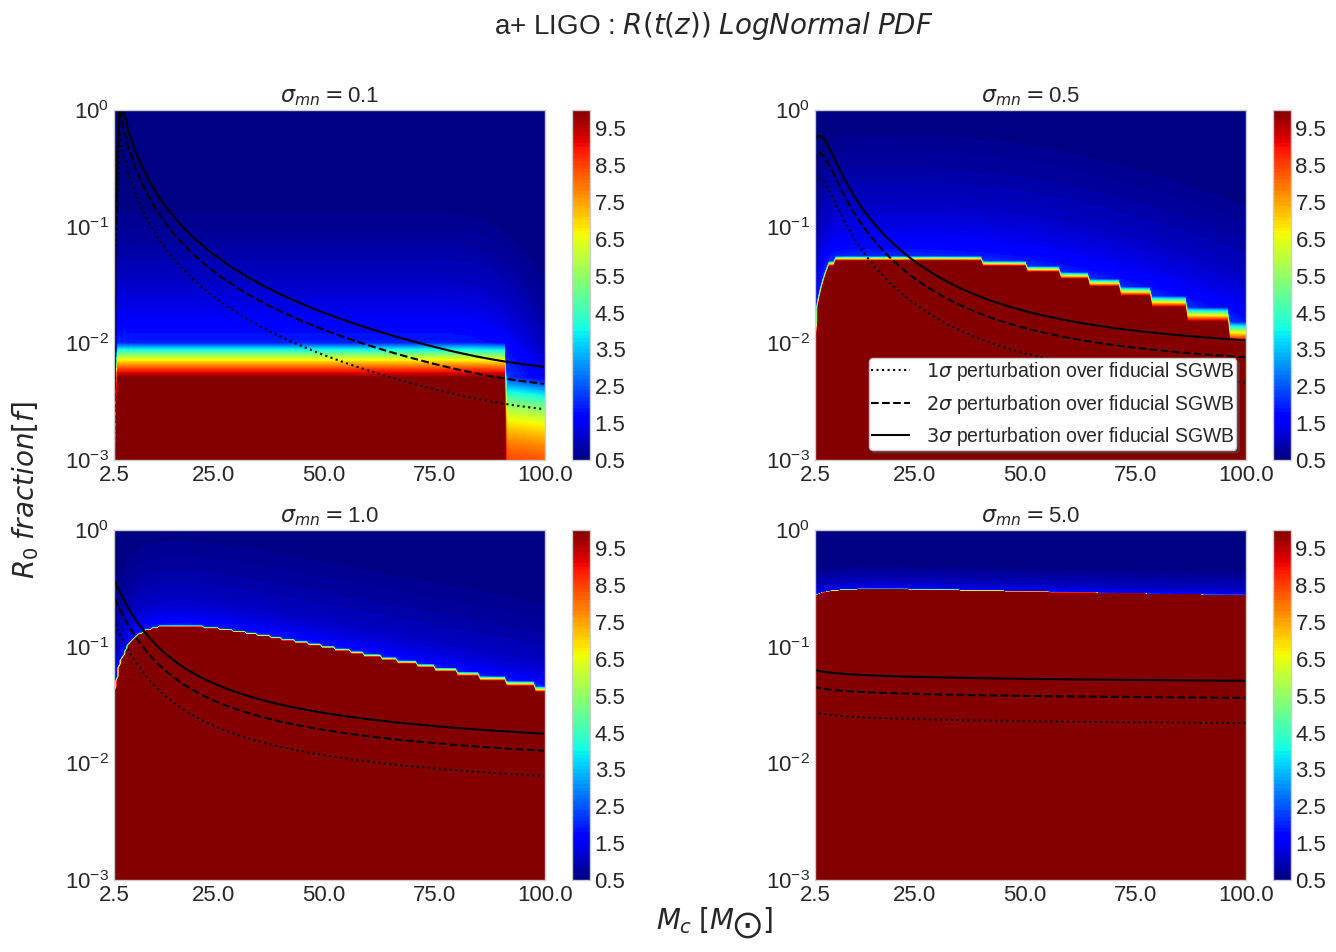

In [20]:
if PBH and PBH_LogNormal:
    fig, ax = plt.subplots(figsize = [16,10], nrows = 2, ncols = 2)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
    fname = 'SGWBPSLNPDF.png'
    contr = {}
    lines = []
    handles = []
    labels = [r'$1\sigma$ perturbation over fiducial SGWB', r'$2\sigma$ perturbation over fiducial SGWB', r'$3\sigma$ perturbation over fiducial SGWB']
    ls_span = ['dotted', 'dashed', 'solid']
    idx = 0
    for i in range(2):
        for j in range(2):
            contr[idx] =ax[i][j].contour(X[idx], Y[idx], Pert_PS[idx], levels = [SGWB_FidNoise[1], SGWB_FidNoise[2], SGWB_FidNoise[3]],colors = ['black', 'black', 'black'], linestyles = ls_span)
            contf = ax[i][j].contourf(X[idx], Y[idx], LIGO_Zdom[idx], 100, cmap='jet')
            fig.colorbar(contf, ax=ax[i][j])
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$\sigma_{mn} = $' + str(PBH_sigmamnspan[idx]) )
            if (i == 0 and j == 1):
                for nlin in range(3):
                    handles, lines = contr[idx].legend_elements()
                ax[i][j].legend(handles, labels,loc=4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1)
            idx += 1
    fig.text(0.06, 0.5, r'$R_0 \; fraction [f]$', va = 'center', rotation='vertical', fontsize = 20)
    fig.text(0.5, 0.06, r'$M_c \; [M_\bigodot]$', ha = 'center', fontsize = 20)
    if PBH_fRt :
        fname = 'Rt' + fname
        fig.suptitle('a+ LIGO : '+r'$R(t(z)) \; LogNormal \;PDF$', fontsize = 20)
    if PBH_fRz :
        fname = 'Rz' + fname
        fig.suptitle('a+ LIGO : '+r'$R(z) \; LogNormal \;PDF $', fontsize = 20)
    fig.savefig('LIGO'+fname, dpi = 500)

In [21]:
if PBH and PBH_Gaussian:
    fig, ax = plt.subplots(figsize = [16,10], nrows = 2, ncols = 2)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
    fname = 'SGWBPSGSPDF.png'
    contr = {}
    lines = []
    handles = []
    labels = [r'$1\sigma$ perturbation over fiducial SGWB', r'$2\sigma$ perturbation over fiducial SGWB', r'$3\sigma$ perturbation over fiducial SGWB']
    ls_span = ['dotted', 'dashed', 'solid']
    idx = 0
    for i in range(2):
        for j in range(2):
            contr[idx] =ax[i][j].contour(X[i], Y[i], Pert_PS[i], levels = [SGWB_FidNoise[1], SGWB_FidNoise[2], SGWB_FidNoise[3]],colors = 'black', linestyles = ls_span)
            contf = ax[i][j].contourf(X[idx], Y[idx], LIGO_Zdom[idx].transpose(), 100, cmap='jet')
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$\sigma_{m} = $' + str(PBH_sigmamspan[idx]) )
            if (i == 0 and j == 1):
                for nlin in range(3):
                    handles, lines = contr[idx].legend_elements()
                ax[i][j].legend(handles, labels,loc=4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1)
            idx += 1
    
    fig.text(0.06, 0.5, r'$R_0 \; fraction [f]$', va = 'center', rotation='vertical', fontsize = 20)
    fig.text(0.5, 0.06, r'$\mu \; [M_\bigodot]$', ha = 'center', fontsize = 20)
    if PBH_fRt :
        fname = 'Rt' + fname
        fig.suptitle('a+ LIGO : '+r'$R(t(z)) \; Gaussian \;PDF$', fontsize = 20)
    if PBH_fRz :
        fname = 'Rz' + fname
        fig.suptitle('a+ LIGO : '+r'$R(z) \; Gaussian \;PDF $', fontsize = 20)
    fig.savefig('LIGO'+fname, dpi = 500)

<h4> Results for Einstein telescope </h4>

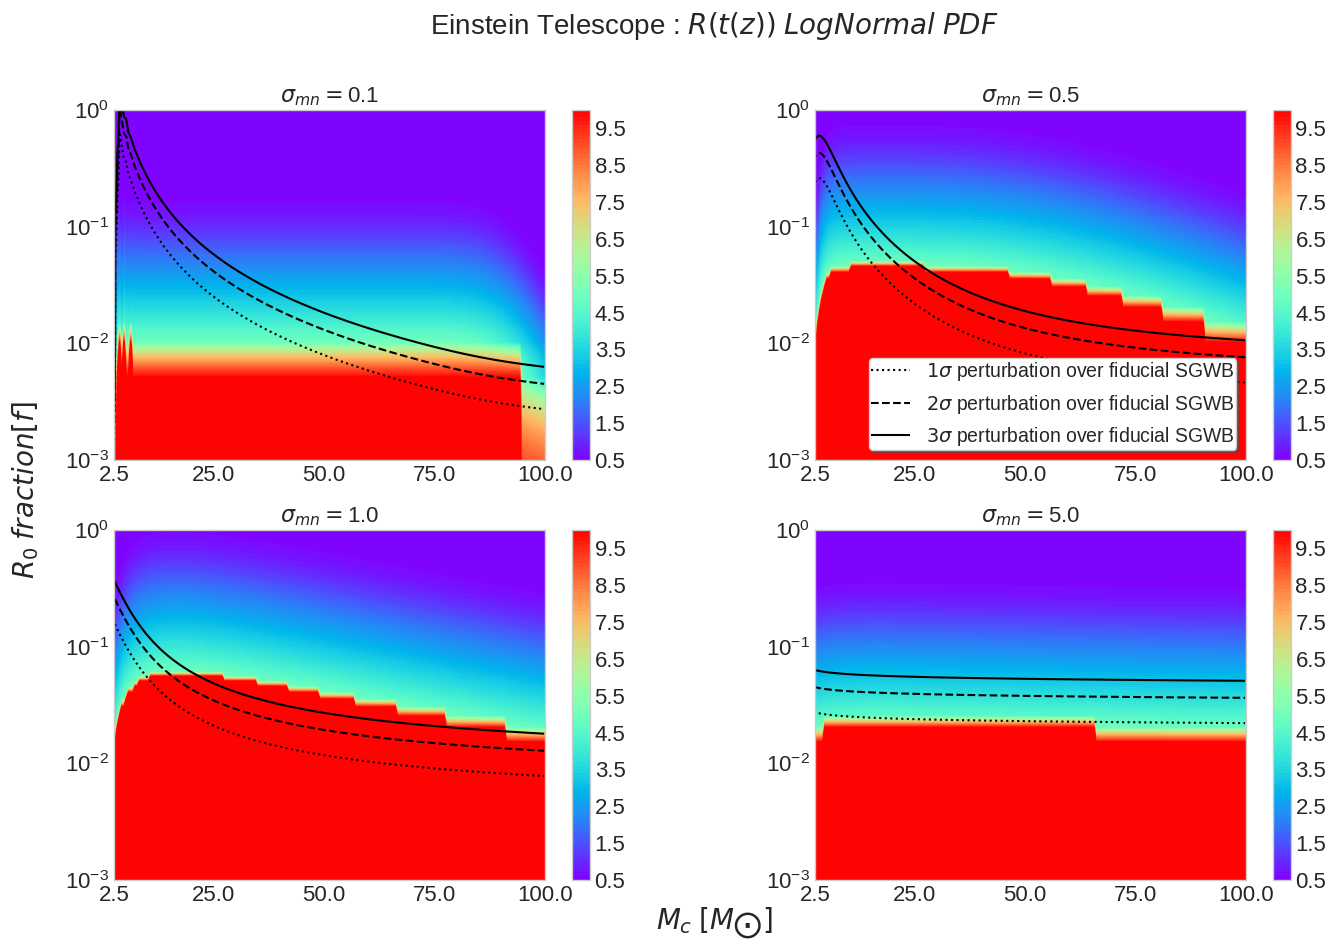

In [22]:
if PBH and PBH_LogNormal:
    fig, ax = plt.subplots(figsize = [16,10], nrows = 2, ncols = 2)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
    fname = 'SGWBPSLNPDF.png'
    contr = {}
    lines = []
    handles = []
    labels = [r'$1\sigma$ perturbation over fiducial SGWB', r'$2\sigma$ perturbation over fiducial SGWB', r'$3\sigma$ perturbation over fiducial SGWB']
    ls_span = ['dotted', 'dashed', 'solid']
    idx = 0
    for i in range(2):
        for j in range(2):
            contr[idx] =ax[i][j].contour(X[idx], Y[idx], Pert_PS[idx], levels = [SGWB_FidNoise[1], SGWB_FidNoise[2], SGWB_FidNoise[3]],colors = ['black', 'black', 'black'], linestyles = ls_span)
            contf = ax[i][j].contourf(X[idx], Y[idx], ET_Zdom[idx], 100, cmap='rainbow')
            fig.colorbar(contf, ax=ax[i][j])
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$\sigma_{mn} = $' + str(PBH_sigmamnspan[idx]) )
            if (i == 0 and j == 1):
                for nlin in range(3):
                    handles, lines = contr[idx].legend_elements()
                ax[i][j].legend(handles, labels,loc=4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1)
            idx += 1
    fig.text(0.06, 0.5, r'$R_0 \; fraction [f]$', va = 'center', rotation='vertical', fontsize = 20)
    fig.text(0.5, 0.06, r'$M_c \; [M_\bigodot]$', ha = 'center', fontsize = 20)
    if PBH_fRt :
        fname = 'Rt' + fname
        fig.suptitle('Einstein Telescope : '+r'$R(t(z)) \; LogNormal \;PDF$', fontsize = 20)
    if PBH_fRz :
        fname = 'Rz' + fname
        fig.suptitle('Einstein Telescope : '+r'$R(z) \; LogNormal \;PDF $', fontsize = 20)
    fig.savefig('ET'+fname, dpi = 500)

In [23]:
if PBH and PBH_Gaussian:
    fig, ax = plt.subplots(figsize = [16,10], nrows = 2, ncols = 2)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
    fname = 'SGWBPSGSPDF.png'
    contr = {}
    lines = []
    handles = []
    labels = [r'$1\sigma$ perturbation over fiducial SGWB', r'$2\sigma$ perturbation over fiducial SGWB', r'$3\sigma$ perturbation over fiducial SGWB']
    ls_span = ['dotted', 'dashed', 'solid']
    idx = 0
    for i in range(2):
        for j in range(2):
            contr[idx] =ax[i][j].contour(X[i], Y[i], Pert_PS[i], levels = [SGWB_FidNoise[1], SGWB_FidNoise[2], SGWB_FidNoise[3]],colors = 'black', linestyles = ls_span)
            contf = ax[i][j].contourf(X[idx], Y[idx], ET_Zdom[idx].transpose(), 100, cmap='rainbow')
            ax[i][j].set_ylim(1e-3,1.)
            ax[i][j].set_yscale('log')
            ax[i][j].set_xlim(2.5,100.)
            ax[i][j].set_xticks([2.5,25., 50., 75., 100.])
            ax[i][j].set_title(r'$\sigma_{m} = $' + str(PBH_sigmamspan[idx]) )
            if (i == 0 and j == 1):
                for nlin in range(3):
                    handles, lines = contr[idx].legend_elements()
                ax[i][j].legend(handles, labels,loc=4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1)
            idx += 1
    
    fig.text(0.06, 0.5, r'$R_0 \; fraction [f]$', va = 'center', rotation='vertical', fontsize = 20)
    fig.text(0.5, 0.06, r'$\mu \; [M_\bigodot]$', ha = 'center', fontsize = 20)
    if PBH_fRt :
        fname = 'Rt' + fname
        fig.suptitle('Einstein Telescope : '+r'$R(t(z)) \; Gaussian \;PDF$', fontsize = 20)
    if PBH_fRz :
        fname = 'Rz' + fname
        fig.suptitle('Einstein Telescope : '+r'$R(z) \; Gaussian \;PDF $', fontsize = 20)
    fig.savefig('ET'+fname, dpi = 500)